In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset (replace the path with your actual file path)
df = pd.read_csv("The Climate Change Twitter Dataset.csv")

In [5]:
# Display the first few rows
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [7]:
# Check for missing values
df.isnull().sum()

created_at                0
id                        0
lng                10481873
lat                10481873
topic                     0
sentiment                 0
stance                    0
gender                    0
temperature_avg    10481873
aggressiveness            0
dtype: int64

In [9]:
# Drop rows where all elements are missing (optional)
df.dropna(how='all', inplace=True)

# Fill numerical columns with median
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [11]:
# Check for duplicates
print("Duplicates found:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

# Verify removal
print("Duplicates after removal:", df.duplicated().sum())

Duplicates found: 0
Duplicates after removal: 0


In [16]:
# Define a function to detect and optionally remove outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print(f"Outliers in {column}: {df[(df[column] < lower) | (df[column] > upper)].shape[0]}")
    
    # Remove outliers
    df = df[(df[column] >= lower) & (df[column] <= upper)]
    return df

# Apply to numerical columns
for col in numerical_cols:
    df = remove_outliers_iqr(df, col)

Outliers in id: 1427608
Outliers in lng: 4811453
Outliers in lat: 81452
Outliers in sentiment: 0
Outliers in temperature_avg: 0


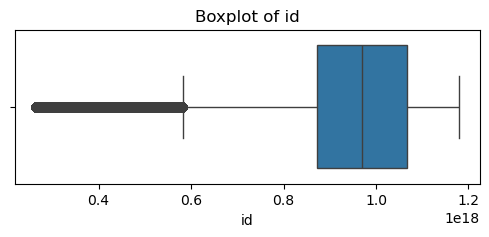

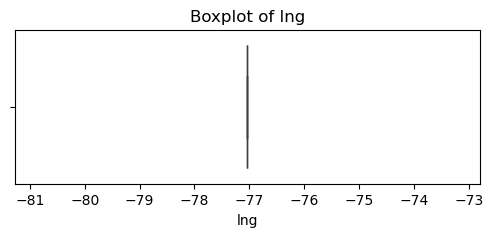

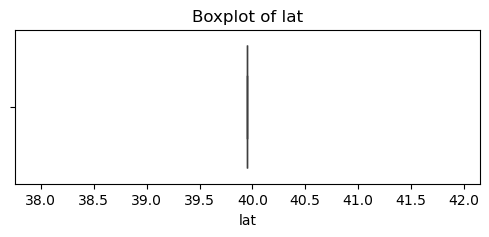

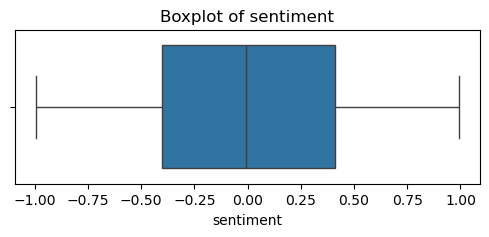

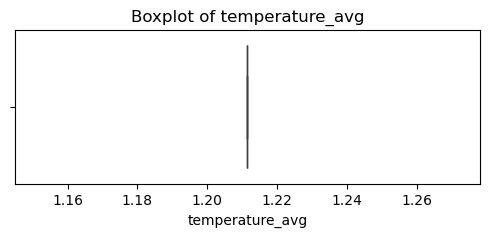

In [18]:
# Visualize boxplots
for col in numerical_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [21]:
# Final dataset shape and info
print("Final dataset shape:", df.shape)
df.info()

Final dataset shape: (9468898, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 9468898 entries, 1427608 to 15789410
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 794.7+ MB


In [23]:
# Check column names and basic info
print(df.columns)
df.info()

# Optional: Rename columns for consistency
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Convert date column to datetime if exists (e.g., 'tweet_created_at')
if 'tweet_created_at' in df.columns:
    df['tweet_created_at'] = pd.to_datetime(df['tweet_created_at'], errors='coerce')

# Extract features from datetime
if 'tweet_created_at' in df.columns:
    df['year'] = df['tweet_created_at'].dt.year
    df['month'] = df['tweet_created_at'].dt.month
    df['day'] = df['tweet_created_at'].dt.day
    df['hour'] = df['tweet_created_at'].dt.hour

Index(['created_at', 'id', 'lng', 'lat', 'topic', 'sentiment', 'stance',
       'gender', 'temperature_avg', 'aggressiveness'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 9468898 entries, 1427608 to 15789410
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 794.7+ MB


In [25]:
from sklearn.preprocessing import LabelEncoder

# Identify object columns
categorical_cols = df.select_dtypes(include='object').columns

# Apply Label Encoding or One-Hot Encoding
le = LabelEncoder()

for col in categorical_cols:
    if df[col].nunique() <= 10:  # suitable for LabelEncoder
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        # For higher cardinality, you may want to drop, encode, or use embeddings in ML
        print(f"Skipping high-cardinality column: {col}")

Skipping high-cardinality column: created_at


In [27]:
# Example: Extract length of tweet
if 'message' in df.columns:
    df['tweet_length'] = df['message'].apply(lambda x: len(str(x)))

In [29]:
# Example: Combine date parts to create a week identifier
if {'year', 'month'}.issubset(df.columns):
    df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

In [31]:
# Create a new feature based on time of day
def get_time_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

if 'hour' in df.columns:
    df['time_period'] = df['hour'].apply(get_time_period)

In [33]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns

# Option 1: Min-Max Scaling
minmax = MinMaxScaler()
df[numerical_cols] = minmax.fit_transform(df[numerical_cols])

In [35]:
# Show cleaned and wrangled data
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
1427608,2012-11-03 09:40:16+00:00,0.000000,0.0,0.0,0.888889,0.741984,1.0,0.0,0.0,1.0
1427609,2012-11-03 09:47:44+00:00,0.000002,0.0,0.0,1.000000,0.745113,1.0,0.0,0.0,1.0
1427610,2012-11-03 09:48:05+00:00,0.000002,0.0,0.0,1.000000,0.751585,1.0,0.5,0.0,1.0
1427612,2012-11-03 09:49:36+00:00,0.000003,0.0,0.0,1.000000,0.375588,1.0,0.5,0.0,1.0
1427613,2012-11-03 09:50:02+00:00,0.000003,0.0,0.0,0.666667,0.549070,0.0,0.0,0.0,1.0


In [37]:
# Save for later use
df.to_csv("cleaned_climate_data.csv", index=False)

In [39]:
user_df = pd.read_csv("disasters.csv")
df = pd.merge(df, user_df, how="left", on="user_id")

KeyError: 'user_id'

In [57]:
# Basic statistics for numeric columns
df[['sentiment', 'temperature_avg']].describe()

,sentiment,temperature_avg
count,9.468898e+06,9468898.0
mean,4.992344e-01,0.0
std,2.206311e-01,0.0
min,0.000000e+00,0.0
25%,2.984084e-01,0.0
50%,4.967238e-01,0.0
75%,7.083396e-01,0.0
max,1.000000e+00,0.0


In [59]:
print("Sentiment Stats")
print("Mean:", df['sentiment'].mean())
print("Median:", df['sentiment'].median())
print("Standard Deviation:", df['sentiment'].std())

print("\nTemperature Avg Stats")
print("Mean:", df['temperature_avg'].mean())
print("Median:", df['temperature_avg'].median())
print("Standard Deviation:", df['temperature_avg'].std())


Sentiment Stats
Mean: 0.4992344331468942
Median: 0.4967237696378243
Standard Deviation: 0.22063105625836724

Temperature Avg Stats
Mean: 0.0
Median: 0.0
Standard Deviation: 0.0


stance
0.0    6938866
1.0    1833738
0.5     696294
Name: count, dtype: int64


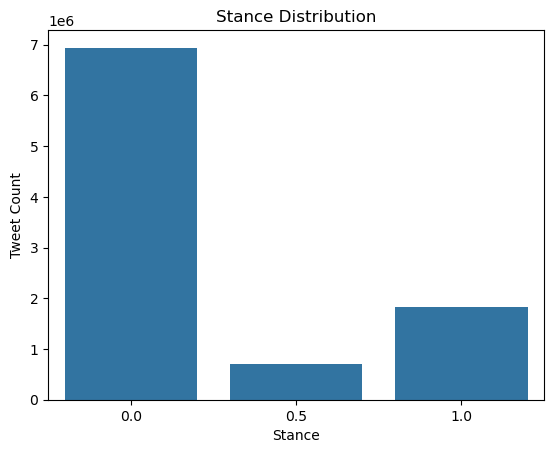

In [63]:
# Frequency of stance
print(df['stance'].value_counts())
sns.countplot(x='stance', data=df)
plt.title('Stance Distribution')
plt.xlabel('Stance')
plt.ylabel('Tweet Count')
plt.show()


gender
0.5    6141158
0.0    2935326
1.0     392414
Name: count, dtype: int64


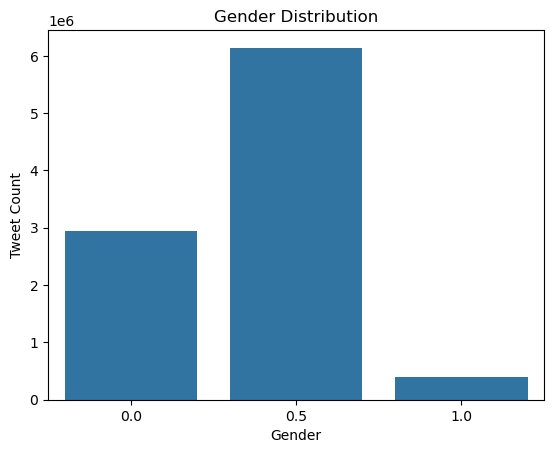

In [65]:
# Frequency of gender
print(df['gender'].value_counts())
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Tweet Count')
plt.show()

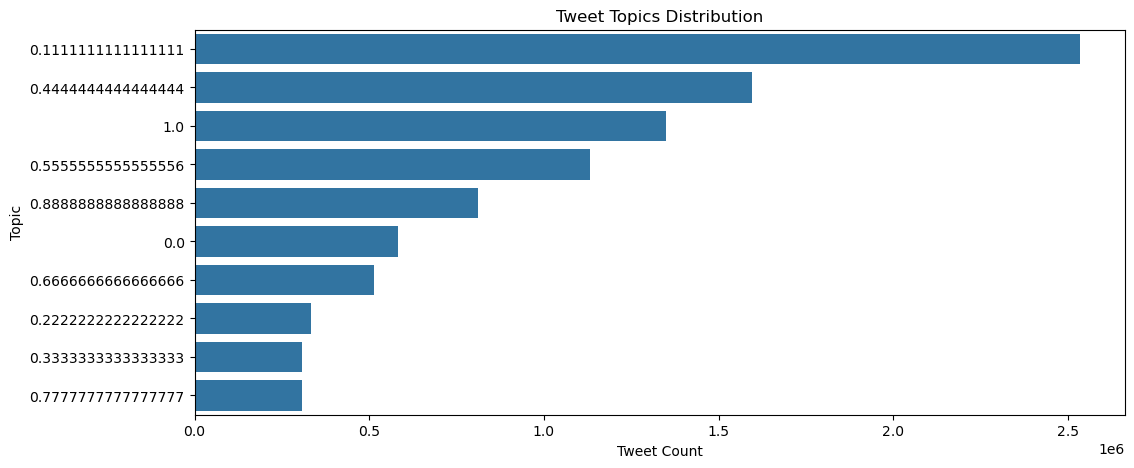

In [67]:
plt.figure(figsize=(12, 5))
sns.countplot(y='topic', data=df, order=df['topic'].value_counts().index)
plt.title('Tweet Topics Distribution')
plt.xlabel('Tweet Count')
plt.ylabel('Topic')
plt.show()

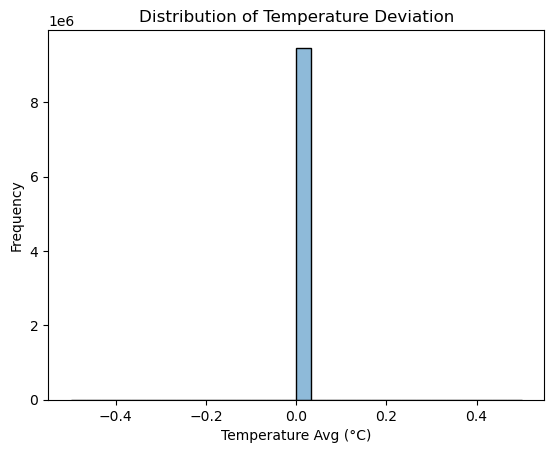

In [69]:
sns.histplot(df['temperature_avg'], kde=True, bins=30)
plt.title('Distribution of Temperature Deviation')
plt.xlabel('Temperature Avg (°C)')
plt.ylabel('Frequency')
plt.show()

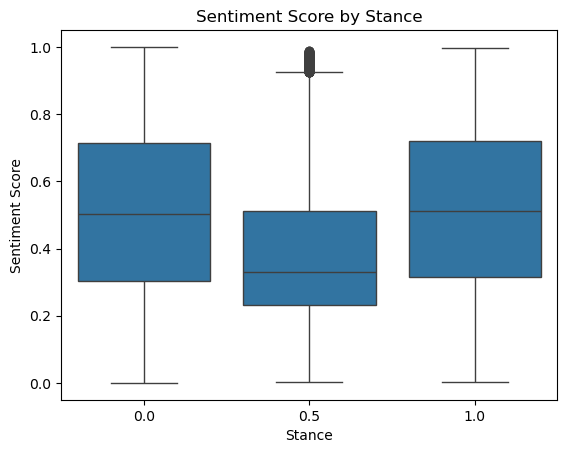

In [71]:
sns.boxplot(x='stance', y='sentiment', data=df)
plt.title('Sentiment Score by Stance')
plt.xlabel('Stance')
plt.ylabel('Sentiment Score')
plt.show()

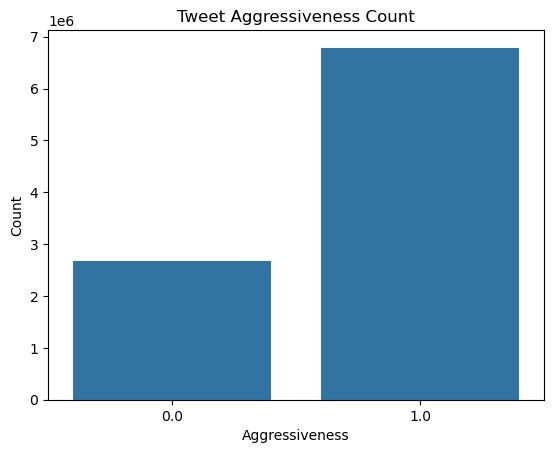

In [73]:
sns.countplot(x='aggressiveness', data=df)
plt.title('Tweet Aggressiveness Count')
plt.xlabel('Aggressiveness')
plt.ylabel('Count')
plt.show()

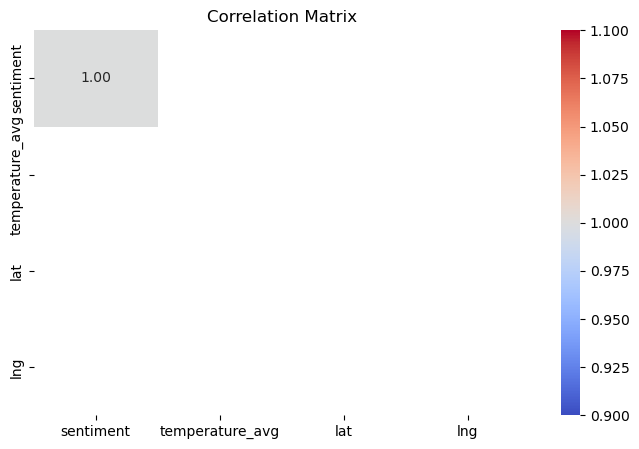

In [75]:
# Select numeric columns
numeric_cols = df[['sentiment', 'temperature_avg', 'lat', 'lng']]
corr = numeric_cols.corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

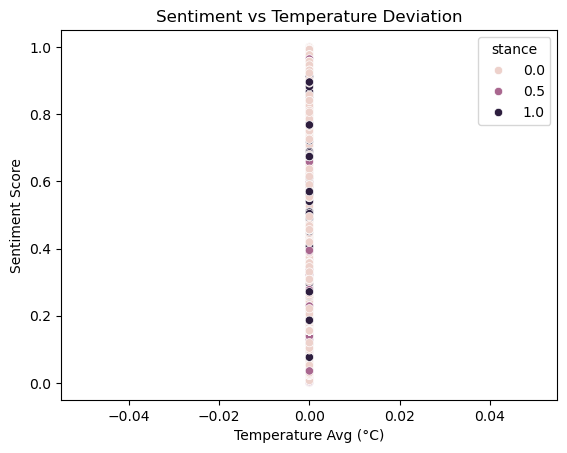

In [77]:
sns.scatterplot(x='temperature_avg', y='sentiment', hue='stance', data=df)
plt.title('Sentiment vs Temperature Deviation')
plt.xlabel('Temperature Avg (°C)')
plt.ylabel('Sentiment Score')
plt.show()


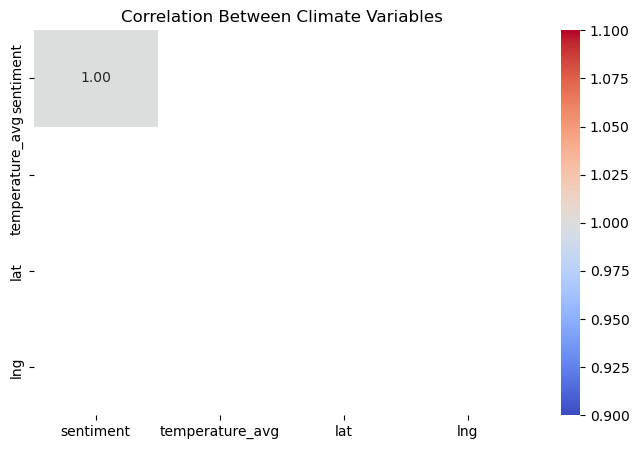

In [79]:
# Select numerical columns for correlation
num_df = df[['sentiment', 'temperature_avg', 'lat', 'lng']]

# Compute correlation matrix
corr = num_df.corr()

# Visualize
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Climate Variables')
plt.show()

In [ ]:
# Detect temperature anomalies (using IQR)
Q1 = df['temperature_avg'].quantile(0.25)
Q3 = df['temperature_avg'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['temperature_avg'] < Q1 - 1.5 * IQR) | (df['temperature_avg'] > Q3 + 1.5 * IQR)]

print("Temperature Anomalies Detected:", len(outliers))

# Plot anomalies
plt.figure(figsize=(10,5))
sns.lineplot(x='created_at', y='temperature_avg', data=df.sort_values('created_at'), label='Temperature')
plt.scatter(outliers['created_at'], outliers['temperature_avg'], color='red', label='Anomalies')
plt.title('Temperature Spikes Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature Deviation')
plt.legend()
plt.show()

Temperature Anomalies Detected: 0


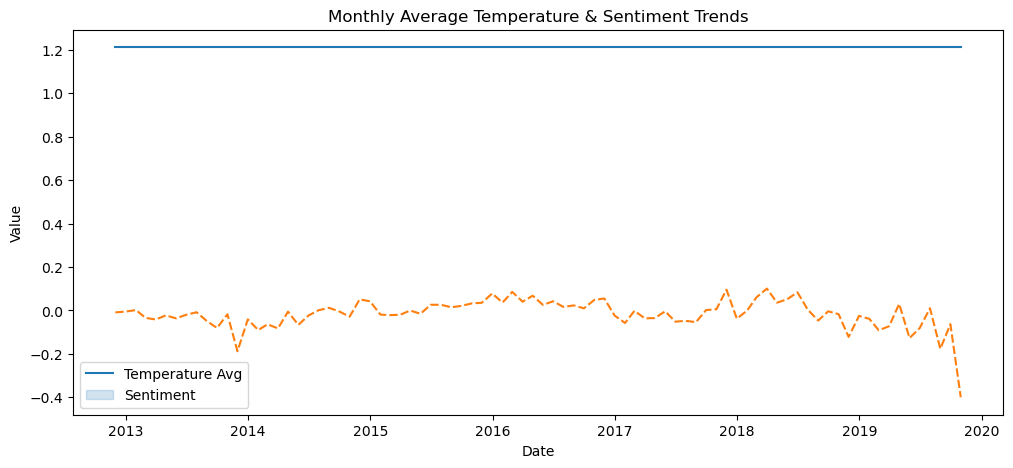

In [22]:
# Ensure datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Resample to monthly averages
monthly_trends = df.set_index('created_at').resample('ME').mean(numeric_only=True)

# Plot trends
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends[['temperature_avg', 'sentiment']])
plt.title('Monthly Average Temperature & Sentiment Trends')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Temperature Avg', 'Sentiment'])
plt.show()

Average Sentiment during COP26: nan
Average Sentiment during Wildfires: nan


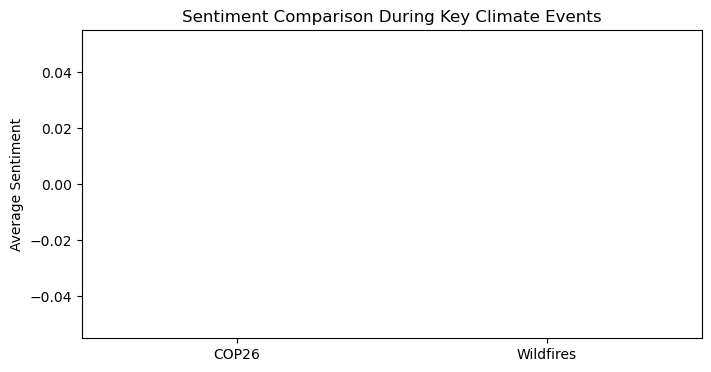

In [24]:
# Define event periods (example)
cop_period = (df['created_at'] >= '2021-10-30') & (df['created_at'] <= '2021-11-13')  # COP26
wildfire_period = (df['created_at'] >= '2020-08-01') & (df['created_at'] <= '2020-08-31')

# Compare sentiment
print("Average Sentiment during COP26:", df[cop_period]['sentiment'].mean())
print("Average Sentiment during Wildfires:", df[wildfire_period]['sentiment'].mean())

# Visual comparison
plt.figure(figsize=(8,4))
sns.barplot(x=['COP26', 'Wildfires'], y=[
    df[cop_period]['sentiment'].mean(),
    df[wildfire_period]['sentiment'].mean()
])
plt.title('Sentiment Comparison During Key Climate Events')
plt.ylabel('Average Sentiment')
plt.show()


In [13]:
# machine learning techniques uses to climate trends
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['topic', 'stance', 'gender', 'aggressiveness']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Drop irrelevant or redundant columns
df_model = df.drop(['id', 'created_at'], axis=1)

# Fill any remaining missing values
df_model = df_model.fillna(df_model.mean(numeric_only=True))


Mean Squared Error (Regression): 4.728996893507019


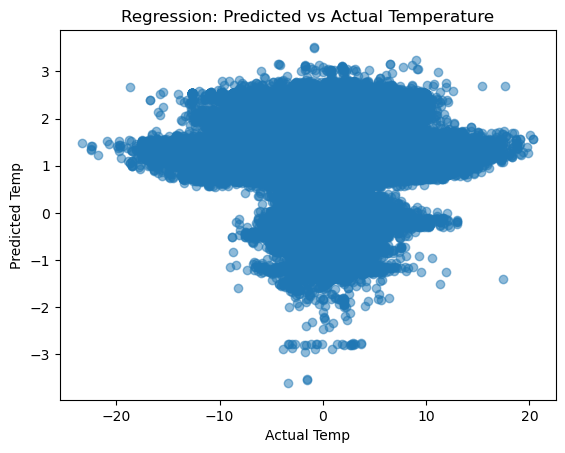

In [17]:
# Features and target
X = df_model[['sentiment', 'stance', 'gender', 'lat', 'lng']]
y = df_model['temperature_avg']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict & evaluate
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (Regression):", mse)

# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Temp")
plt.ylabel("Predicted Temp")
plt.title("Regression: Predicted vs Actual Temperature")
plt.show()


In [21]:
# Features and target
X = df_model[['sentiment', 'temperature_avg', 'lat', 'lng', 'topic']]
y = df_model['stance']  # Already label encoded

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix - Climate Stance")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KeyboardInterrupt: 

In [ ]:
# Features
X = df_model[['lat', 'lng', 'temperature_avg', 'sentiment']]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize
plt.figure(figsize=(10,6))
sns.scatterplot(x='lng', y='lat', hue='cluster', data=df_model, palette='Set2')
plt.title("Clustering of Tweets by Geographic and Climate Features")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


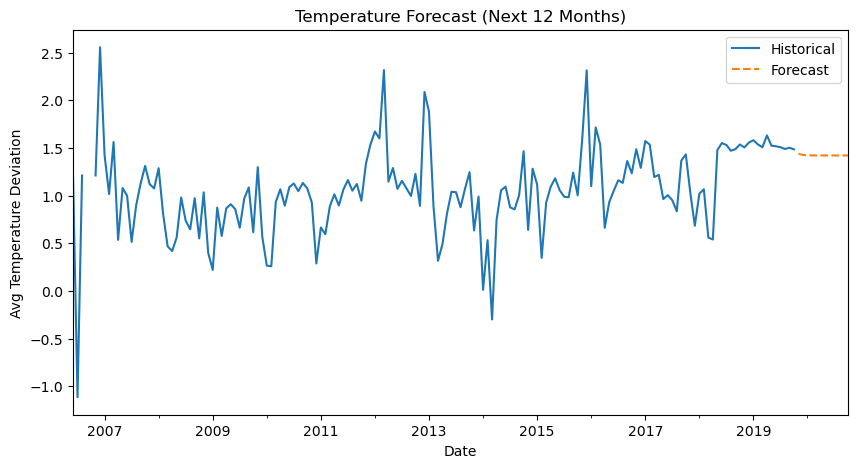

In [20]:
# Convert and set datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df_ts = df.set_index('created_at').resample('M').mean(numeric_only=True)

# Forecast future temperature using simple ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA
model = ARIMA(df_ts['temperature_avg'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot
df_ts['temperature_avg'].plot(label='Historical', figsize=(10,5))
forecast.plot(label='Forecast', linestyle='--')
plt.title('Temperature Forecast (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Avg Temperature Deviation')
plt.legend()
plt.show()


In [23]:
import joblib
joblib.dump(lr, 'temperature_regression_model.pkl')
joblib.dump(clf, 'stance_classifier_model.pkl')

['stance_classifier_model.pkl']